In [1]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.3 MB/s eta 0:00:00


# **Import libraries**

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.figure_factory as ff
import plotly.offline as py
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV, validation_curve, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




# **Display dataset**

In [3]:
warnings.simplefilter(action='ignore', category=Warning)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
df = pd.read_csv("data.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.990,10.380,122.800,1001.000,0.118,0.278,0.300,0.147,...,17.330,184.600,2019.000,0.162,0.666,0.712,0.265,0.460,0.119,NaN
1,842517,M,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,...,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089,NaN
2,84300903,M,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,...,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088,NaN
3,84348301,M,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,...,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173,NaN
4,84358402,M,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,...,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077,NaN


# **Overall picture of dataset**

In [4]:
df.shape

(569, 33)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,569.000,30371831.432,125020585.612,8670.000,869218.000,906024.000,8813129.000,911320502.000
radius_mean,569.000,14.127,3.524,6.981,11.700,13.370,15.780,28.110
texture_mean,569.000,19.290,4.301,9.710,16.170,18.840,21.800,39.280
perimeter_mean,569.000,91.969,24.299,43.790,75.170,86.240,104.100,188.500
area_mean,569.000,654.889,351.914,143.500,420.300,551.100,782.700,2501.000
smoothness_mean,569.000,0.096,0.014,0.053,0.086,0.096,0.105,0.163
compactness_mean,569.000,0.104,0.053,0.019,0.065,0.093,0.130,0.345
concavity_mean,569.000,0.089,0.080,0.000,0.030,0.062,0.131,0.427
concave points_mean,569.000,0.049,0.039,0.000,0.020,0.034,0.074,0.201
symmetry_mean,569.000,0.181,0.027,0.106,0.162,0.179,0.196,0.304


In [7]:
df.nunique()

,0
id,569
diagnosis,2
radius_mean,456
texture_mean,479
perimeter_mean,522
area_mean,539
smoothness_mean,474
compactness_mean,537
concavity_mean,537
concave points_mean,542


# **Drop useless columns**


*   Due to an error in dataset, there is 'Unnamed: 32' columns which is completely NaN.
*   Column 'id' is not required to predict breast cancer.



In [8]:
df = df.drop(['Unnamed: 32', 'id'], axis=1)
print(df.shape)
df.head()

(569, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.990,10.380,122.800,1001.000,0.118,0.278,0.300,0.147,0.242,...,25.380,17.330,184.600,2019.000,0.162,0.666,0.712,0.265,0.460,0.119
1,M,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,0.181,...,24.990,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089
2,M,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,0.207,...,23.570,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088
3,M,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,0.260,...,14.910,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173
4,M,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,0.181,...,22.540,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077


# **Change diagnosis column to numeric values**

In [9]:
df.diagnosis.replace({'M': 1, 'B': 0}, inplace=True)
df.tail()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
564,1,21.560,22.390,142.000,1479.000,0.111,0.116,0.244,0.139,0.173,...,25.450,26.400,166.100,2027.000,0.141,0.211,0.411,0.222,0.206,0.071
565,1,20.130,28.250,131.200,1261.000,0.098,0.103,0.144,0.098,0.175,...,23.690,38.250,155.000,1731.000,0.117,0.192,0.322,0.163,0.257,0.066
566,1,16.600,28.080,108.300,858.100,0.085,0.102,0.093,0.053,0.159,...,18.980,34.120,126.700,1124.000,0.114,0.309,0.340,0.142,0.222,0.078
567,1,20.600,29.330,140.100,1265.000,0.118,0.277,0.351,0.152,0.240,...,25.740,39.420,184.600,1821.000,0.165,0.868,0.939,0.265,0.409,0.124
568,0,7.760,24.540,47.920,181.000,0.053,0.044,0.000,0.000,0.159,...,9.456,30.370,59.160,268.600,0.090,0.064,0.000,0.000,0.287,0.070


# **Distribution of target values**

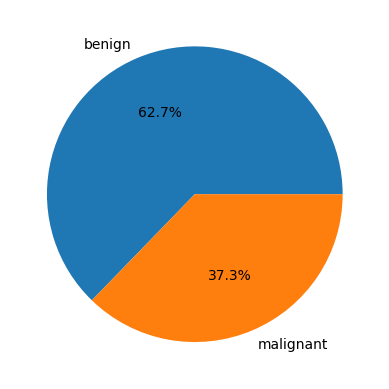

In [10]:
def plot_target(dataframe, labels):
  fig, ax = plt.subplots()
  ax.pie(df.diagnosis.value_counts(), labels=labels, autopct='%1.1f%%')
  plt.show()

plot_target(df, labels=['benign','malignant'])

# **Plot number of features**

<Axes: >

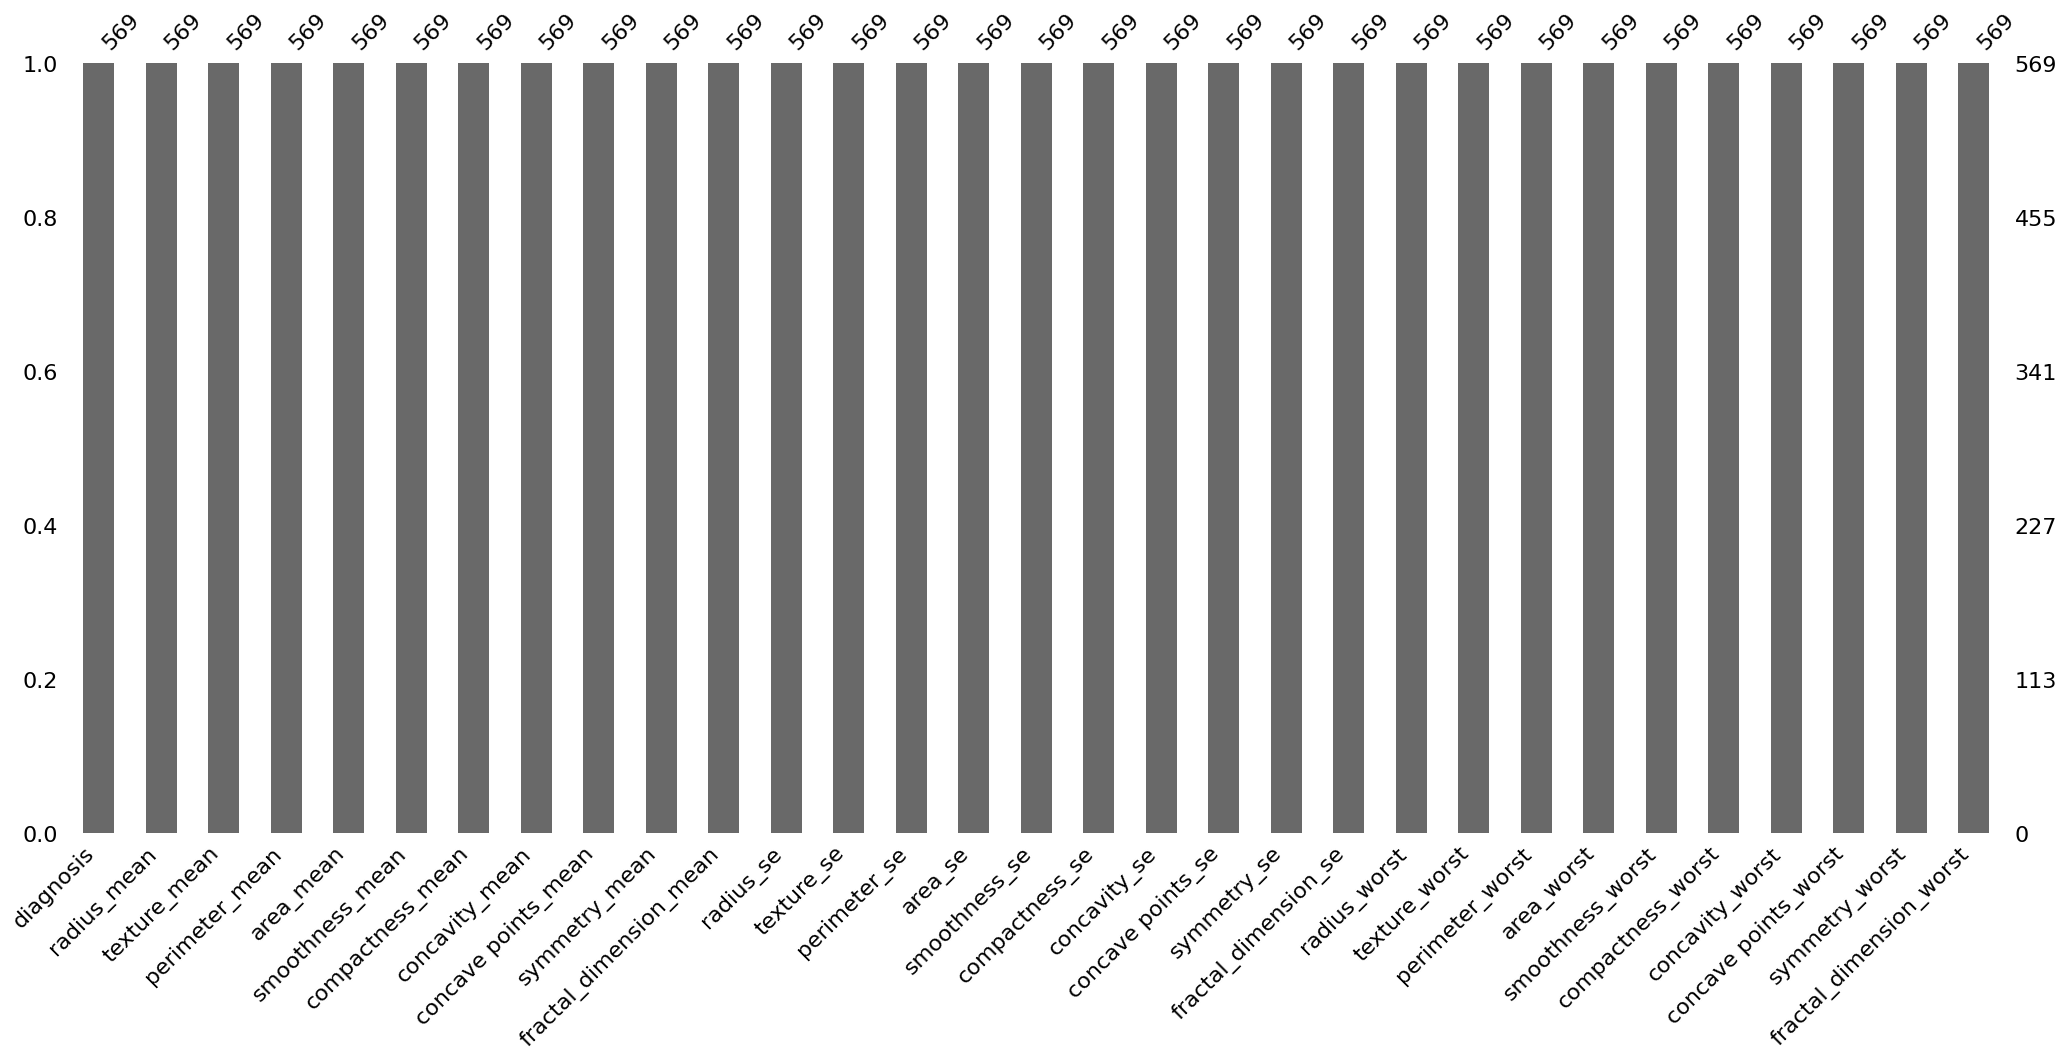

In [11]:
msno.bar(df)

# **Distribution of features**

In [12]:
def dist(data, bin_size):
  M = df[df['diagnosis'] == 1]
  B = df[df['diagnosis'] == 0]
  tmp1 = M[data]
  tmp2 = B[data]
  hist_data = [tmp1, tmp2]

  group_labels = ['malignant', 'benign']

  fig = ff.create_distplot(hist_data, group_labels, show_hist = True, bin_size = bin_size, curve_type='kde')

  fig['layout'].update(title = data)

  return fig

def plot_dist(dataframe, prefix, bin_size=.5):
  cols = [col for col in dataframe.columns if col.startswith(prefix)]

  for i, col in enumerate(cols):
    dist_fig = dist(col, bin_size)
    py.iplot(dist_fig, filename = 'Density plot')

In [13]:
plot_dist(df, 'radius', 1)
plot_dist(df, 'texture', 1)
plot_dist(df, 'perimeter', 1)
plot_dist(df, 'area', 1)
plot_dist(df, 'smoothness', 1)
plot_dist(df, 'compactness', 1)
plot_dist(df, 'concavity', 1)
plot_dist(df, 'concave points', 1)
plot_dist(df, 'symmetry', 1)
plot_dist(df, 'fractal_dimension', 1)

# **Plot correlation between features with heatmap**


*   Find the high correlated columns and drop them.

* Reduced number of features 31 to 21.






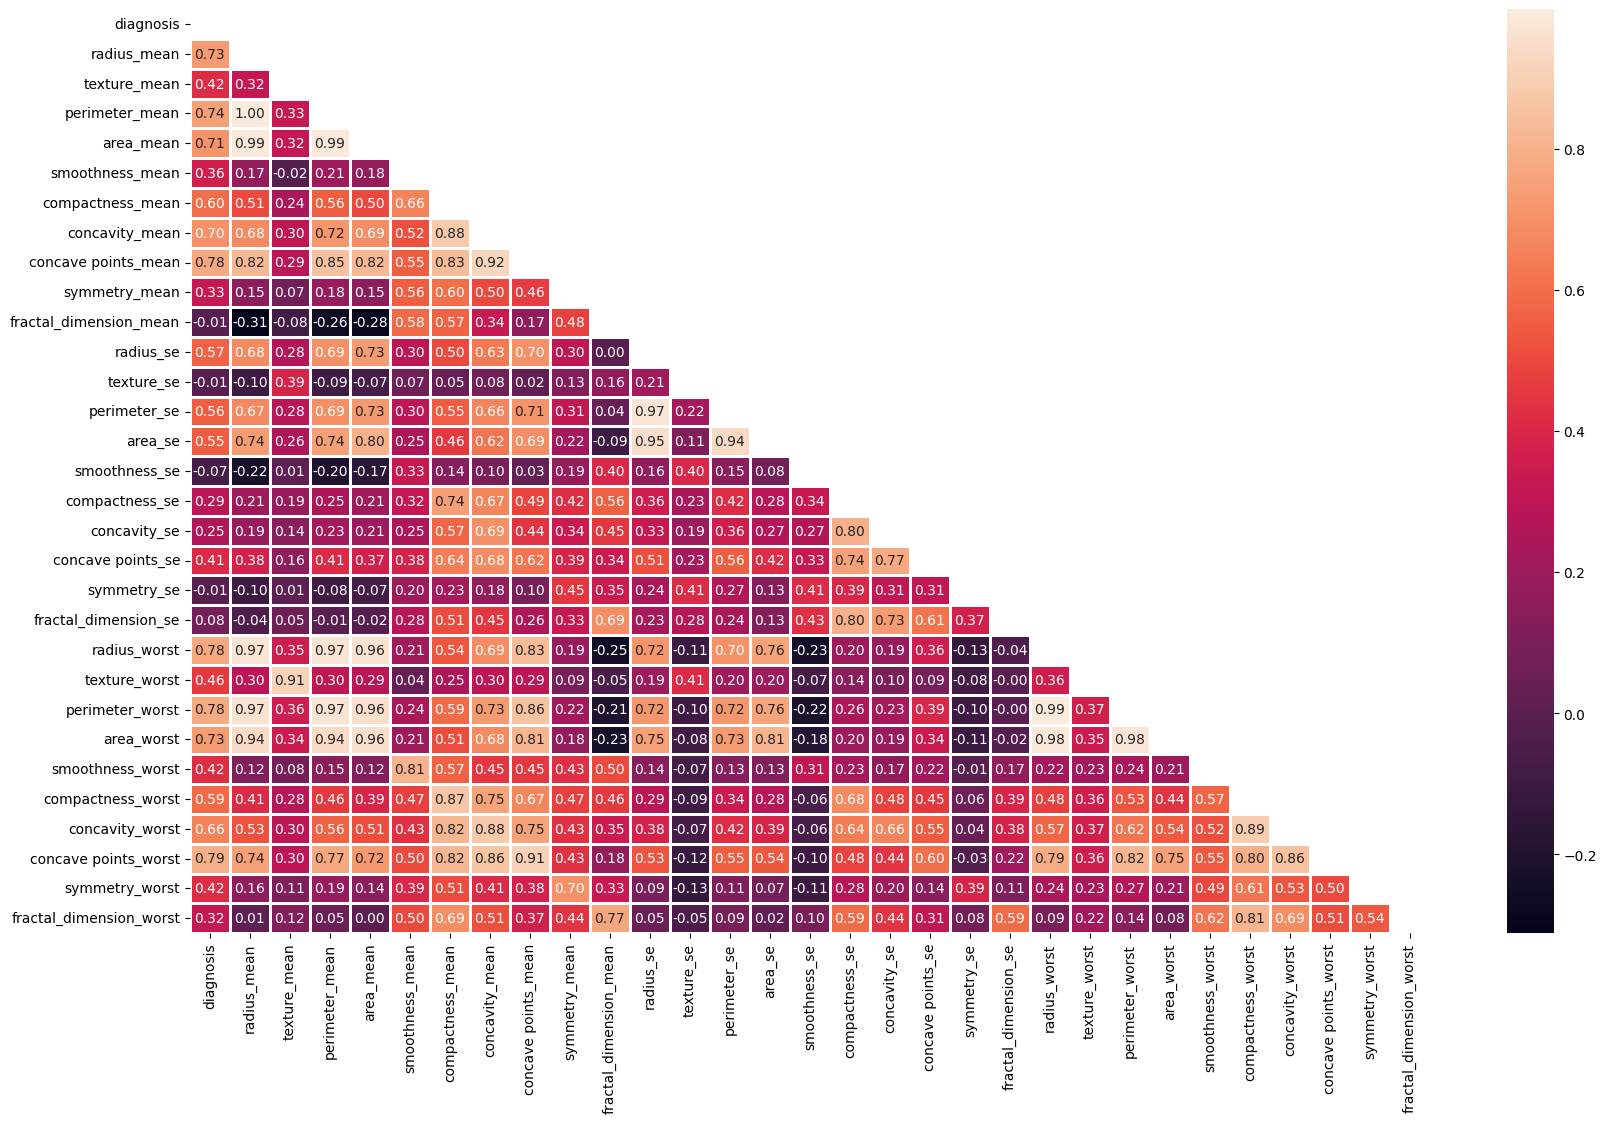

In [14]:
def plot_heatmap(dataframe):
  plt.figure(figsize = (20, 12))

  corr = dataframe.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))

  sns.heatmap(corr, mask=mask, linewidths=1, annot=True, fmt=".2f")
  plt.show()

plot_heatmap(df)

In [15]:
def high_correlated_cols(dataframe, threshold=0.9):
  corr = dataframe.corr()
  corr_matrix = corr.abs()
  upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
  drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > threshold)]

  return drop_list

drop_list = high_correlated_cols(df)

print(drop_list)
df2 = df.drop(drop_list, axis=1)

print(df2.shape)
df2.head()

['perimeter_mean', 'area_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']
(569, 21)


,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,...,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
0,1,17.990,10.380,0.118,0.278,0.300,0.242,0.079,1.095,0.905,...,0.049,0.054,0.016,0.030,0.006,0.162,0.666,0.712,0.460,0.119
1,1,20.570,17.770,0.085,0.079,0.087,0.181,0.057,0.543,0.734,...,0.013,0.019,0.013,0.014,0.004,0.124,0.187,0.242,0.275,0.089
2,1,19.690,21.250,0.110,0.160,0.197,0.207,0.060,0.746,0.787,...,0.040,0.038,0.021,0.022,0.005,0.144,0.424,0.450,0.361,0.088
3,1,11.420,20.380,0.142,0.284,0.241,0.260,0.097,0.496,1.156,...,0.075,0.057,0.019,0.060,0.009,0.210,0.866,0.687,0.664,0.173
4,1,20.290,14.340,0.100,0.133,0.198,0.181,0.059,0.757,0.781,...,0.025,0.057,0.019,0.018,0.005,0.137,0.205,0.400,0.236,0.077


# **Principal Component Analysis**

In [16]:
x = df.drop(['diagnosis'], axis=1)
y = df['diagnosis']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

pca = PCA()
pca.fit_transform(x_train)
pca.fit(x_test)

PCA()

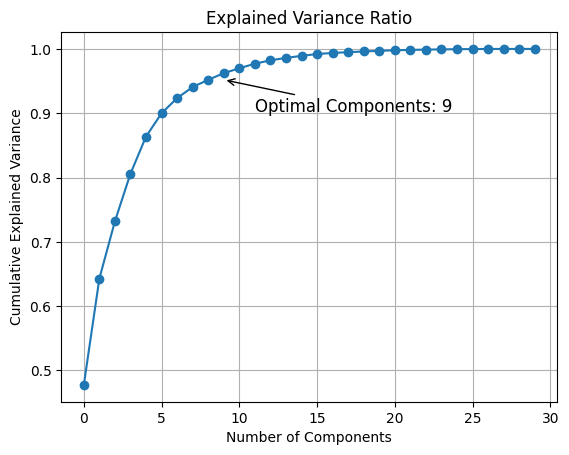

In [17]:
explained_var_ratio = pca.explained_variance_ratio_
cum_var_ratio = np.cumsum(explained_var_ratio)
optimal_components = np.argmax(cum_var_ratio >= 0.95) + 1

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

plt.annotate(f'Optimal Components: {optimal_components}',
             xy=(optimal_components, cum_var_ratio[optimal_components-1]),
             xytext=(optimal_components + 2, cum_var_ratio[optimal_components-1] - 0.05),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12)

plt.grid(True)

# **Recursive feature elimination with cross validation**


*   Identified the best features for achieving the highest accuracy.



In [19]:
models = {
      "LogisticRegression": LogisticRegression(),
      "RandomForest":  RandomForestClassifier(random_state=17),
      "GradientBoosting": GradientBoostingClassifier(random_state=17),
      "XGBoost": XGBClassifier(random_state=17, use_label_encoder=False),
      "LightGBM": LGBMClassifier(random_state=17, verbose=-1),
      "CatBoost": CatBoostClassifier(random_state=17, verbose=False),
      "AdaBoost": AdaBoostClassifier(random_state=17)
}

features = dict()

for i, (model_name, model) in enumerate(models.items()):
  rfecv = RFECV(estimator=model, step=5, cv=5, scoring='accuracy')
  rfecv.fit(x_train, y_train)
  print(f"Model: {model_name}\n")
  print('Optimal number of features :', rfecv.n_features_)
  print('Best features :', x.columns[rfecv.support_])
  print("------------------------------------------------------------")
  features.update({model_name: x.columns[rfecv.support_]})


Model: LogisticRegression

Optimal number of features : 10
Best features : Index(['compactness_mean', 'concave points_mean', 'radius_se', 'area_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst', 'area_worst',
       'concavity_worst', 'concave points_worst'],
      dtype='object')
--------------------------------------------------
Model: RandomForest

Optimal number of features : 20
Best features : Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'concavity_mean', 'concave points_mean', 'radius_se', 'perimeter_se',
       'area_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
--------------------------------------------------
Model: GradientBoosting

Optimal number of features : 15
Best features : Index(['texture_mean', 'conca

In [ ]:
def plot_confusion_matrix():
  #TODO
  pass

def plot_roc_curve():
  #TODO
  pass

def plot_precision_recall_curve():
  #TODO
  pass

def learning_curve():
  #TODO
  pass

In [ ]:
def train():
  #TODO
  pass

def model_info():
  #TODO
  pass

def hyperparameter_tuning():
  #TODO
  pass